In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
df = pd.read_csv('temp.csv')

In [3]:
df.head()

station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax   
0      1.0  30-06-2013          28.7          21.4    58.255688    91.116364  \
1      2.0  30-06-2013          31.9          21.6    52.263397    90.604721   
2      3.0  30-06-2013          31.6          23.3    48.690479    83.973587   
3      4.0  30-06-2013          32.0          23.4    58.239788    96.483688   
4      5.0  30-06-2013          31.4          21.9    56.174095    90.155128   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS    LDAPS_LH  ...  LDAPS_PPT2   
0         28.074101         23.006936  6.818887   69.451805  ...         0.0  \
1         29.850689         24.035009  5.691890   51.937448  ...         0.0   
2         30.091292         24.565633  6.138224   20.573050  ...         0.0   
3         29.704629         23.326177  5.650050   65.727144  ...         0.0   
4         29.113934         23.486480  5.735004  107.965535  ...         0.0   

   LDAPS_PPT3  LDAPS_PPT4      lat      lon       DEM   Slope   
0         0.0         0.0  37.6046  126.991  212.3350  2.7850  \
1         0.0         0.0  37.6046  127.032   44.7624  0.5141   
2         0.0         0.0  37.5776  127.058   33.3068  0.2661   
3         0.0         0.0  37.6450  127.022   45.7160  2.5348   
4         0.0         0.0  37.5507  127.135   35.0380  0.5055   

   Solar radiation  Next_Tmax  Next_Tmin  
0      5992.895996       29.1       21.2  
1      5869.312500       30.5       22.5  
2      5863.555664       31.1       23.9  
3      5856.964844       31.7       24.3  
4      5859.552246       31.2       22.5  

[5 rows x 25 columns]

In [4]:
df.dtypes.value_counts()

float64    24
object      1
Name: count, dtype: int64

In [5]:
df.shape

(7752, 25)

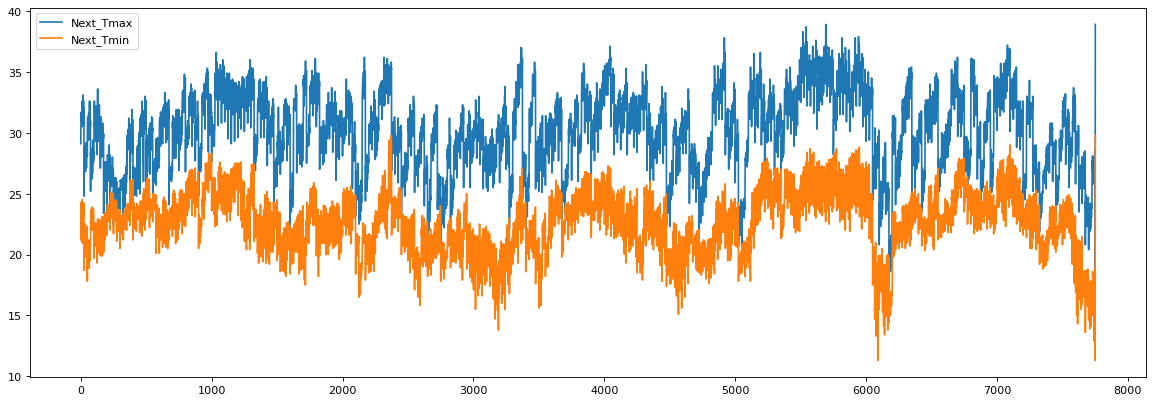

In [6]:
plt.figure(figsize=(18, 6), dpi=80)
plt.plot(df["Next_Tmax"],label="Next_Tmax")
plt.plot(df["Next_Tmin"],label="Next_Tmin")
plt.legend()
plt.show()

In [7]:
for col in ["Next_Tmax","Next_Tmin"]:
    plt.figure()
    sns.displot(df[col],kind='kde')
    plt.show()
print(df["Next_Tmax"].mean())
print(df["Next_Tmax"].std())
print(df["Next_Tmin"].mean())
print(df["Next_Tmin"].std())

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

30.274886731391586
3.128010057855773
22.93222006472492
2.487612771331068


In [9]:
df = pd.read_csv('temp.csv')
Save = df.copy()
def feature_engineering(df):
    df = df.drop(["Date"],axis=1)
    print(df.dtypes.value_counts()) # Compte les nombre de types de variables
    return(df)
def imputation(df):
    #df = df.fillna(-999)
    df = df.dropna(axis=0)
    return df
def encodage(df):
    return df
def preprocessing(df):
    df = imputation(df)
    df = encodage(df)
    df = feature_engineering(df)
    
    X = df.drop(['Next_Tmax','Next_Tmin'],axis=1)
    y_max = df["Next_Tmax"]
    y_min = df["Next_Tmin"]
    
    print(X.shape)
    print(y_max.shape)
    
    return X,y_max,y_min


In [10]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)
X_train, y_min_train, y_max_train = preprocessing(trainset)
X_test, y_min_test, y_max_test = preprocessing(testset)

float64    24
Name: count, dtype: int64
(6068, 22)
(6068,)
float64    24
Name: count, dtype: int64
(1520, 22)
(1520,)


In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate
reg_max = make_pipeline(StandardScaler(),
                    SGDRegressor(loss='squared_error', penalty='l2', max_iter=1000, tol=1e-3))
reg_max.fit(X_train, y_max_train)

reg_min = make_pipeline(StandardScaler(),
                    SGDRegressor(loss='squared_error', penalty='l2', max_iter=1000, tol=1e-3))
reg_min.fit(X_train, y_min_train)

cv_results_min = cross_validate(reg_min, X_train, y_min_train, cv=5, scoring=('r2', "neg_root_mean_squared_error"), return_train_score=True)
cv_results_max = cross_validate(reg_max, X_train, y_max_train, cv=5, scoring=('r2', "neg_root_mean_squared_error"), return_train_score=True)

print('Pour le Next_Tmin :')
print('Test RMSE :' , -cv_results_min['test_neg_root_mean_squared_error'].mean())
print('Test r2 :' , cv_results_min['test_r2'].mean())
print("Train RMSE :" , -cv_results_min['train_neg_root_mean_squared_error'].mean())
print("Train r2 :" , cv_results_min['train_r2'].mean())
print("*------------------------------------------*")
print('Pour le Next_Tmax :')
print('Test RMSE :' , -cv_results_max['test_neg_root_mean_squared_error'].mean())
print('Test r2 :' , cv_results_max['test_r2'].mean())
print("Train RMSE :" , -cv_results_max['train_neg_root_mean_squared_error'].mean())
print("Train r2 :" , cv_results_max['train_r2'].mean())

Pour le Next_Tmin :
Test RMSE : 1.4709171980429594
Test r2 : 0.7755105542423235
Train RMSE : 1.4674309033198587
Train r2 : 0.776845738521495
*------------------------------------------*
Pour le Next_Tmax :
Test RMSE : 1.00904835967932
Test r2 : 0.8339213718299389
Train RMSE : 1.0059597733013654
Train r2 : 0.8354433161620994


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 130],
    'max_features': [3, 6],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [4, 8],
    'n_estimators': [1000, 500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
# Fit the grid search to the Max data

grid_search.fit(X_train, y_max_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_max_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
{'bootstrap': True, 'max_depth': 70, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}
Model Performance
Average Error: 0.5535 degrees.
Accuracy = 97.51%.


In [14]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_max_train)
base_accuracy = evaluate(base_model, X_test, y_max_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.6310 degrees.
Accuracy = 97.16%.
Improvement of 0.36%.


In [15]:

grid_search.fit(X_train, y_min_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_min_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
{'bootstrap': True, 'max_depth': 70, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1000}
Model Performance
Average Error: 0.6875 degrees.
Accuracy = 97.69%.


In [16]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_min_train)
base_accuracy = evaluate(base_model, X_test, y_min_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.7870 degrees.
Accuracy = 97.36%.
Improvement of 0.34%.


In [17]:
Next_Tmax_TreeRegressor = RandomForestRegressor(random_state = 42, 
                                                bootstrap=True, max_depth=110, max_features=4, 
                                                min_samples_leaf=2, min_samples_split=4, n_estimators=900)
Next_Tmin_TreeRegressor = RandomForestRegressor(random_state = 42, 
                                                bootstrap=True, max_depth=70, max_features=6, 
                                                min_samples_leaf=2, min_samples_split=4, n_estimators=900)


print("---Next_Tmax---")
Next_Tmax_TreeRegressor.fit(X_train,y_max_train)
Next_Tmax_Accuracy = evaluate(Next_Tmax_TreeRegressor, X_test, y_max_test)

base_max_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_max_model.fit(X_train, y_max_train)
base_max_accuracy = evaluate(base_max_model, X_test, y_max_test)

print('Improvement of {:0.2f}%.'.format( 100 * (Next_Tmax_Accuracy - base_max_accuracy) / base_max_accuracy))
print("---------")


print("---Next_Tmin---")
Next_Tmin_TreeRegressor.fit(X_train,y_min_train)
Next_Tmin_Accuracy = evaluate(Next_Tmin_TreeRegressor, X_test, y_min_test)

base_min_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_min_model.fit(X_train, y_min_train)
base_min_accuracy = evaluate(base_min_model, X_test, y_min_test)

print('Improvement of {:0.2f}%.'.format( 100 * (Next_Tmin_Accuracy - base_min_accuracy) / base_min_accuracy))
print("---------")

---Next_Tmax---
Model Performance
Average Error: 0.5598 degrees.
Accuracy = 97.48%.
Model Performance
Average Error: 0.6310 degrees.
Accuracy = 97.16%.
Improvement of 0.33%.
---------
---Next_Tmin---
Model Performance
Average Error: 0.6888 degrees.
Accuracy = 97.69%.
Model Performance
Average Error: 0.7870 degrees.
Accuracy = 97.36%.
Improvement of 0.33%.
---------
